In [1]:
import cobaya
from cobaya.likelihood import Likelihood
from cobaya.model import get_model
from cobaya.model import Model
from cobaya.run import run
import numpy as np
from astropy.io import fits
from typing import Optional

import matplotlib.pyplot as plt
import vega.vega_interface
import vega.model
import vega.power_spectrum
from vega.vega_interface import VegaInterface, Minimizer

import scipy
from scipy.interpolate import interp1d, InterpolatedUnivariateSpline

In [2]:
class Likelihood(Likelihood): # class that inherits from cobaya.likelihood

    correlation_type: Optional[str]

    def initialize(self, **params_values):
        '''
        Set up initial parameters
        '''
        self.vega = VegaInterface('configs/complex_main.ini') # Creates an instance of VegaInterface with a configuration file containing cosmological or model parameters
        
        # Check if we need to run over a Monte Carlo mock
        if 'control' in self.vega.main_config:
            run_montecarlo = self.vega.main_config['control'].getboolean('run_montecarlo', False)
            if run_montecarlo and self.vega.mc_config is not None:
                # Get the MC seed and forecast flag
                seed = self.vega.main_config['control'].getint('mc_seed', 0)
                forecast = self.vega.main_config['control'].getboolean('forecast', False)

                # Create the mocks
                self.vega.monte_carlo_sim(self.vega.mc_config['params'], seed=seed, forecast=forecast)

                # Set to sample the MC params
                sampling_params = self.vega.mc_config['sample']
                self.vega.minimizer = Minimizer(self.vega.chi2, sampling_params)
            elif run_montecarlo:
                raise ValueError('You asked to run over a Monte Carlo simulation,'
                                 ' but no "[monte carlo]" section provided.')
        
        self.effective_redshift = 2.33
        self.k_grid = np.logspace(-3,1,260) # grid of scales for power spectrum
        self.vega.fiducial['z_fiducial'] = self.effective_redshift   # fix z_eff z_fiducial
        self.vega_model_init = self.vega.compute_model(self.vega.mc_config['params'])
        self.vega_fake_data = self.vega.data['lyalya_lyalya'].mc_mock

    def get_requirements(self):
        '''
        Specifies what cosmological parameters are required by cobaya
        '''
        reqs = {'bias_LYA': None, 'beta_LYA': None,'D_M_fid': None, 'D_H_fid': None, 'or_photon':None, 'or_neutrino':None, \
                'H0': None, 'ombh2': None , 'omch2': None, 'omnuh2': None, 'omk': None,'As': None, 'ns': None, \
                'Pk_grid': {'z': [self.effective_redshift], 'k_max':10, 'nonlinear':[False]},
                'angular_diameter_distance':{'z': [self.effective_redshift]}, 'Hubble':{'z': [self.effective_redshift]},
                }
        #print("Correlation type:", self.correlation_type)
        if self.correlation_type=='AUTO+CROSS':
            reqs['sigma_velo_disp_lorentz_QSO']=None
            reqs['bias_QSO']=None
            reqs['sigma8_z'] = {'z': [self.effective_redshift]} # needed?
            reqs['fsigma8'] = {'z': [self.effective_redshift]}

        return reqs

    def logp(self, **params_values):
        '''
        Method to calculate the log-likelihood based on the parameters provided
        '''
        scale_factor = 1/(1+self.effective_redshift) # scale factor at effective redshift
        h = params_values['H0']/100 # defines the reduced Hubble constant from provided H0
        D_M = (self.provider.get_angular_diameter_distance(self.effective_redshift)/scale_factor)*h # computes angular diameter distance to effective redshift 
        D_H = ((scipy.constants.c/1000)/self.provider.get_Hubble(self.effective_redshift))*h # computes Hubble distance
        params_values['ap_full'] = D_H[0]/params_values['D_H_fid'] # computes alpha_parallel 
        params_values['at_full'] = D_M[0]/params_values['D_M_fid'] # computes alpha_transverse

        if self.correlation_type=='AUTO+CROSS':
            growth_rate = (self.provider.get_fsigma8(self.effective_redshift))/(self.provider.get_sigma8_z(self.effective_redshift))
            #print('growth rate from CAMB:', growth_rate)
            params_values["growth_rate"] = growth_rate[0]
            params_values["_derived"]["growth_rate"] = growth_rate[0]
            params_values["_derived"]["f_sigma8"] = self.provider.get_fsigma8(self.effective_redshift)[0]

        k_Mpc, z, pk_Mpc = self.provider.get_Pk_grid(nonlinear = False) # retrieves power spectrum
        cs = interp1d(np.array(k_Mpc/h), np.array(pk_Mpc*(h**3)), kind='cubic')
        k_hMpc = self.k_grid # initial grid is in units of Mpc/h
        pk_hMpc = cs(k_hMpc)
        
        if 'pk_full' not in self.vega.fiducial.keys(): # if vega fiducial pk_full is empty, store it here
            print("self.vega.fiducial is empty")
            self.vega.fiducial['k'] = k_hMpc
            self.vega.fiducial['pk_full'] = pk_hMpc
        self.pk_full = pk_hMpc
        
        omega_m = (params_values['ombh2'] + params_values['omch2'] + params_values['omnuh2'])/(h**2) # computes Omega_m from baryons, cold dark matter, and non-relativistic neutrinos 
        self.vega.fiducial['Omega_m'] = omega_m
        self.vega.fiducial['Omega_de'] = (1 - params_values['omk'] - params_values['or_photon'] - params_values['or_neutrino'] - omega_m) # computes Omega_de from Omega_m, flatness, photons, and relativistic neutrinos

        # compute and save model
        self.vega_model = self.vega.compute_model(params_values, direct_pk = self.pk_full, run_init=False)
        print('vega model computed')

        template_chi2 = self.vega.chi2(params_values)
        print('param values:', params_values)
        print('template chi2:', template_chi2)
        chi2 = self.vega.chi2(params_values, direct_pk = self.pk_full) # uses vega to compute chi2 from power spectrum and parameter values 
        print('chi2:', chi2, '\n')
        return -chi2 / 2 # returns log likelihood

In [26]:
info_minimize = {
    "output": None,
    "likelihood": {
        "custom_likelihood": {
            "class": Likelihood
        }
    },
    "params": {
        "As": {
            "latex": "A_s",
            "value": 2.1e-9
        },
        "D_H_fid": {
            "latex": "D_{H, fid}",
            "value": 853.772277153506
        },
        "D_M_fid": {
            "latex": "D_{M, fid}",
            "value": 3882.64271129613
        },
        "H0": {
            "prior": {
                "min": 40,
                "max": 100
            },
            "ref": {
                "dist": "norm",
                "loc": 67.36,
                "scale": 3
            },
            "latex": "H_0"
        },
        "rdrag": {
            "latex": "r_d"
        },
        "H0_rd": {
            "derived": "lambda H0, rdrag: H0*rdrag/299792"
        },
        "beta_LYA": {
            "latex": r"\beta",
            "value": 1.67
        },
        "bias_LYA": {
            "latex": "bias",
            "value": -0.1171
        },
        "or_photon": {
            "value": 5.44985776336301e-05,
            "latex": r"\Omega_{r,\gamma}"
        },
        "or_neutrino": {
            "value": 2.5133613689346e-05,
            "latex": r"\Omega_{r,\nu}"
        },
        "ns": {
            "latex": "n_s",
            "value": 0.9649
        },
        "ombh2": {
            "latex": r"\Omega_\mathrm{b} h^2",
            "value": 0.02237
        },
        "omch2": {
            "value": "lambda omegam, ombh2, mnu, H0: (omegam)*(H0/100)**2 - ombh2 -(mnu*(3.046/3)**0.75)/94.0708",
            "latex": r"\Omega_\mathrm{c} h^2"
        },
        "omegam": {
            "prior": {
                "min": 0.01,
                "max": 0.99
            },
            "latex": r"\Omega_\mathrm{m}"
        },
        "omegal": {
            "latex": r"\Omega_\Lambda"
        },
        "mnu": 0.06,
        "tau": 0.055
    },
    "sampler": {
        "minimize": {
            "method": "iminuit",
            "max_evals": 1e6
        }
    },
    "theory": {
        "camb": {
            "extra_args": {
                "WantDerivedParameters": True
            }
        }
    }
}

In [21]:
# from yaml file for info_full-As_lya_minimize.yaml (to recreate issue of nonzero chi2 for no distortion case)
info_minimize = {
    "theory": {
        "camb": {
            "extra_args": {
                "WantDerivedParameters": True
            }
        }
    },
    "output": None, #"/pscratch/sd/w/wmturner/LyA-directfit/minimize_test/nuisance_cosmo/nuisance_cosmo",
    "likelihood": {
        "custom_likelihood": {
            "class": Likelihood
        }
    },
    "params": {
        "D_H_fid": {
            "latex": "D_{H, fid}",
            "value": 853.772253428897
        },
        "D_M_fid": {
            "latex": "D_{M, fid}",
            "value": 3882.64266625345
        },
        "As": {
            "value": 2.1e-9,
            "latex": "A_{s}"
        },
        "ns": {
            "prior": {
                "min": 0.8,
                "max": 1.2
            },
            "ref": {
                "dist": "norm",
                "loc": 0.9649,
                "scale": 0.05
            },
            "latex": "n_{s}"
        },
        "bias_LYA": {
            "latex": "bias",
            "prior": {
                "min": -0.2,
                "max": 0
            },
            "ref": {
                "dist": "norm",
                "loc": -0.117,
                "scale": 0.01
            }
        },
        "beta_LYA": {
            "latex": r"\beta_{LYA}",
            "prior": {
                "min": 0,
                "max": 5
            },
            "ref": {
                "dist": "norm",
                "loc": 1.67,
                "scale": 0.02
            }
        },
        "H0": {
            "prior": {
                "min": 40,
                "max": 100
            },
            "ref": {
                "dist": "norm",
                "loc": 67.36,
                "scale": 3
            },
            "latex": "H_0"
        },
        "rdrag": {
            "latex": "r_d"
        },
        "H0_rd": {
            "derived": "lambda H0, rdrag: H0*rdrag/299792",
            "latex": "H_{0}r_{d}/c"
        },
        "ombh2": {
            "prior": {
                "min": 0.01,
                "max": 0.05
            },
            "latex": r"\Omega_\mathrm{b} h^2"
        },
        "omch2": {
            "value": "lambda omegam, ombh2, mnu, H0: (omegam)*(H0/100)**2 - ombh2 -(mnu*(3.046/3)**0.75)/94.0708",
            "latex": r"\Omega_\mathrm{c} h^2"
        },
        "omegam": {
            "prior": {
                "min": 0.01,
                "max": 0.99
            },
            "ref": 0.315094454725487,
            "proposal": 0.1,
            "latex": r"\Omega_\mathrm{m}"
        },
        "omegal": {
            "latex": r"\Omega_\Lambda"
        },
        "mnu": 0.06,
        "tau": 0.055,
        "or_photon": {
            "value": 5.4502399977451e-05,
            "latex": r"\Omega_{r,\gamma}"
        },
        "or_neutrino": {
            "value": 2.51353764750397e-05,
            "latex": r"\Omega_{r,\nu}"
        }
    },
    "sampler": {
        "minimize": {
            "method": "iminuit",
            "max_evals": 1e6
        }
    }
}

In [36]:
# omch2 instead of omega_m
info_minimize = {
    "theory": {
        "camb": {
            "extra_args": {
                "WantDerivedParameters": True
            }
        }
    },
    "output": None,
    "likelihood": {
        "custom_likelihood": {
            "class": Likelihood
        }
    },
    "params": {
        "D_H_fid": {
            "latex": "D_{H, fid}",
            "value": 853.772253428897
        },
        "D_M_fid": {
            "latex": "D_{M, fid}",
            "value": 3882.64266625345
        },
        "As": {
            "value": 2.1e-9,
            "latex": "A_{s}"
        },
        "ns": {
            "prior": {
                "min": 0.8,
                "max": 1.2
            },
            "ref": {
                "dist": "norm",
                "loc": 0.9649,
                "scale": 0.05
            },
            "latex": "n_{s}"
        },
        "bias_LYA": {
            "latex": "bias",
            "prior": {
                "min": -0.2,
                "max": 0
            },
            "ref": {
                "dist": "norm",
                "loc": -0.117,
                "scale": 0.01
            }
        },
        "beta_LYA": {
            "latex": r"\beta_{LYA}",
            "prior": {
                "min": 0,
                "max": 5
            },
            "ref": {
                "dist": "norm",
                "loc": 1.67,
                "scale": 0.02
            }
        },
        "H0": {
            "prior": {
                "min": 40,
                "max": 100
            },
            "ref": {
                "dist": "norm",
                "loc": 67.36,
                "scale": 3
            },
            "latex": "H_0"
        },
        "rdrag": {
            "latex": "r_d"
        },
        "H0_rd": {
            "derived": "lambda H0, rdrag: H0*rdrag/299792",
            "latex": "H_{0}r_{d}/c"
        },
        "ombh2": {
            "prior": {
                "min": 0.01,
                "max": 0.05
            },
            "latex": r"\Omega_\mathrm{b} h^2"
        },
        "omch2": {
            #"value": "lambda omegam, ombh2, mnu, H0: (omegam)*(H0/100)**2 - ombh2 -(mnu*(3.046/3)**0.75)/94.0708",
            #"value": 0.12,
            "prior": {
                "min": 0.01,
                "max": 0.2
            },
            "latex": r"\Omega_\mathrm{c} h^2"
        },
        #"omegam": {
        #    "prior": {
        #        "min": 0.01,
        #        "max": 0.99
        #    },
        #    "ref": 0.315094454725487,
        #    "proposal": 0.1,
        #    "latex": r"\Omega_\mathrm{m}"
        #},
        "omegam": {
            "latex": r"\Omega_m"
        },
        "omegal": {
            "latex": r"\Omega_\Lambda"
        },
        #"mnu": 0.06,
        #"tau": 0.055,
        "or_photon": {
            "value": 5.4502399977451e-05,
            "latex": r"\Omega_{r,\gamma}"
        },
        "or_neutrino": {
            "value": 2.51353764750397e-05,
            "latex": r"\Omega_{r,\nu}"
        }
    },
    "sampler": {
        "minimize": {
            "method": "iminuit",
            "max_evals": 1e6
        }
    }
}

In [75]:
# fixed cosmo params
info_minimize_fixedcosmo = {
    "theory": {
        "camb": {
            "extra_args": {
                "WantDerivedParameters": True
            }
        }
    },
    "output": "/pscratch/sd/w/wmturner/LyA-directfit/minimize_test/nuisance_model/nuisance_model",
    "likelihood": {
        "custom_likelihood": {
            "class": Likelihood
        }
    },
    "params": {
        "D_H_fid": {
            "latex": "D_{H, fid}",
            "value": 853.772253428897
        },
        "D_M_fid": {
            "latex": "D_{M, fid}",
            "value": 3882.64266625345
        },
        "As": {
            "value": 2.1e-9,
            "latex": "A_{s}"
        },
        "ns": {
            "value": 0.9649,
            "latex": "n_{s}"
        },
        "bias_LYA": {
            "latex": "bias",
            "prior": {
                "min": -0.2,
                "max": 0
            },
            "ref": {
                "dist": "norm",
                "loc": -0.117,
                "scale": 0.01
            }
        },
        "beta_LYA": {
            "latex": r"\beta_{LYA}",
            "prior": {
                "min": 0,
                "max": 5
            },
            "ref": {
                "dist": "norm",
                "loc": 1.67,
                "scale": 0.02
            }
        },
        "H0": {
            "value": 67.36,
            "latex": "H_0"
        },
        "rdrag": {
            "latex": "r_d"
        },
        "H0_rd": {
            "derived": "lambda H0, rdrag: H0*rdrag/299792",
            "latex": "H_{0}r_{d}/c"
        },
        "ombh2": {
            "value": 0.02237,
            "latex": r"\Omega_\mathrm{b} h^2"
        },
        "omch2": {
            "value": "lambda omegam, ombh2, mnu, H0: (omegam)*(H0/100)**2 - ombh2 -(mnu*(3.046/3)**0.75)/94.0708",
            #"value": 0.12,
            "latex": r"\Omega_\mathrm{c} h^2"
        },
        "omegam": {
            "value": 0.315094454725487,
            "latex": r"\Omega_\mathrm{m}"
        },
        "omegal": {
            "latex": r"\Omega_\Lambda"
        },
        "mnu": 0.06,
        "tau": 0.055,
        "or_photon": {
            "value": 5.4502399977451e-05,
            "latex": r"\Omega_{r,\gamma}"
        },
        "or_neutrino": {
            "value": 2.51353764750397e-05,
            "latex": r"\Omega_{r,\nu}"
        }
    },
    "sampler": {
        "minimize": {
            "method": "iminuit",
            "max_evals": 1e6
        }
    }
}

In [3]:
# fixed cosmo, free omegam (auto only)
info_minimize = {
    "theory": {
        "camb": {
            "extra_args": {
                "WantDerivedParameters": True
            }
        }
    },
    "output": None,#"/pscratch/sd/w/wmturner/LyA-directfit/minimize_test/nuisance_omegam/nuisance_omegam",
    "likelihood": {
        "custom_likelihood": {
            "class": Likelihood,
            "correlation_type": 'AUTO'
        }
    },
    "params": {
        "D_H_fid": {
            "latex": "D_{H, fid}",
            "value": 853.772253428897
        },
        "D_M_fid": {
            "latex": "D_{M, fid}",
            "value": 3882.64266625345
        },
        "logA": {
            "value": 3.044522437723423,
            "latex": r"\log(10^{10} A_\mathrm{s})",
            "drop": True
        },
        "As": {
            "value": 'lambda logA: 1e-10*np.exp(logA)',
            "latex": r"A_\mathrm{s}"
        },
        #"As": {
        #    "value": 2.1e-9,
        #    "latex": "A_{s}"
        #},
        "ns": {
            "value": 0.9649,
            "latex": "n_{s}"
        },
        "log_biasLYA": {
            "prior": {
              "min": -2.,
              "max": 0
            },
            "ref": -0.93,
            "latex": r"log(bias_{LYA})"
        },
        "bias_LYA": {
            "value": 'lambda log_biasLYA: -10**(log_biasLYA)' ,
            "latex": r"bias_{LYA}"
        },
        #"bias_LYA": {
        #    "latex": "bias",
        #    "prior": {
        #        "min": -0.2,
        #        "max": 0
        #    },
        #    "ref": {
        #        "dist": "norm",
        #        "loc": -0.117,
        #        "scale": 0.01
        #    }
        #},
        "beta_LYA": {
            "latex": r"\beta_{LYA}",
            "prior": {
                "min": 0,
                "max": 5
            },
            "ref": {
                "dist": "norm",
                "loc": 1.67,
                "scale": 0.02
            }
        },
        "H0": {
            "value": 67.36,
            "latex": "H_0"
        },
        "rdrag": {
            "latex": "r_d"
        },
        "H0_rd": {
            "derived": "lambda H0, rdrag: H0*rdrag/299792",
            "latex": "H_{0}r_{d}/c"
        },
        "ombh2": {
            "value": 0.02237,
            "latex": r"\Omega_\mathrm{b} h^2"
        },
        "omch2": {
            "value": "lambda omegam, ombh2, mnu, H0: (omegam)*(H0/100)**2 - ombh2 -(mnu*(3.046/3)**0.75)/94.0708",
            #"value": 0.12,
            "latex": r"\Omega_\mathrm{c} h^2"
        },
        "omegam": {
            "prior": {
                "min": 0.01,
                "max": 0.99
            },
            "ref": 0.31509,
            "proposal": 0.1,
            "latex": r"\Omega_\mathrm{m}"
        },
        "omegal": {
            "latex": r"\Omega_\Lambda"
        },
        "mnu": 0.06,
        "tau": 0.055,
        "or_photon": {
            "value": 5.4502399977451e-05,
            "latex": r"\Omega_{r,\gamma}"
        },
        "or_neutrino": {
            "value": 2.51353764750397e-05,
            "latex": r"\Omega_{r,\nu}"
        }
    },
    "sampler": {
        "minimize": {
            "method": "iminuit",
            "max_evals": 1e6
        }
    }
}

In [32]:
# auto+cross
info_minimize = {
    "theory": {
        "camb": {
            "extra_args": {
                "WantDerivedParameters": True
            }
        }
    },
    "output": None,
    "likelihood": {
        "custom_likelihood": {
            "class": Likelihood,
            "correlation_type": 'AUTO+CROSS',
            "output_params": {
               "growth_rate": {
                 "derived": True},
               "f_sigma8": {
                 "derived": True}}
        }
    },
    "params": {
        "D_H_fid": {
            "latex": "D_{H, fid}",
            "value": 853.772253428897
        },
        "D_M_fid": {
            "latex": "D_{M, fid}",
            "value": 3882.64266625345
        },
        "growth_rate": {
            "latex": "f",
            "derived": True
        },
        "f_sigma8": {
         "latex": r"f\sigma_8",
         "derived": True
        },
        "logA": {
            "prior": {
              "min": 0.5,
              "max": 6
            },
            "ref": 3.05,
            "latex": r"\log(10^{10} A_\mathrm{s})",
            "drop": True
        },
        "As": {
            "value": 'lambda logA: 1e-10*np.exp(logA)',
            "latex": r"A_\mathrm{s}"
        },
        "ns": {
            "latex": "n_{s}",
            "value": 0.9649
        },
        #"ns": {
        #    "prior": {
        #        "min": 0.8,
        #        "max": 1.2
        #    },
        #    "ref": {
        #        "dist": "norm",
        #        "loc": 0.9649,
        #        "scale": 0.05
        #    },
        #    "latex": "n_{s}"
        #},
        "log_biasLYA": {
            "prior": {
              "min": -2.,
              "max": 0
            },
            "ref": -0.93,
            "latex": r"log(bias_{LYA})"
        },
        "bias_LYA": {
            "value": 'lambda log_biasLYA: -10**(log_biasLYA)' ,
            "latex": r"bias_{LYA}"
        },
        "beta_LYA": {
            "latex": r"\beta_{LYA}",
            "prior": {
                "min": 0,
                "max": 5
            },
            "ref": {
                "dist": "norm",
                "loc": 1.67,
                "scale": 0.02
            }
        },
        "bias_QSO": {
            "prior": {
              "min": 3.4,
              "max": 4.2
            },
              "latex": r"bias_{QSO}"
        },
        "beta_QSO": {
            "latex": r"\beta_{QSO}",
            "derived": 'lambda bias_QSO, growth_rate: growth_rate/bias_QSO'
                },
        "sigma_velo_disp_lorentz_QSO": {
            "prior": {
              "min": 0,
              "max": 15
            },
            "ref": 3.18,
            "latex": r"\sigma_{Lorentz}"
        },
        "H0": {
            "latex": "H_0",
            "value": 67.36
        },
        #"H0": {
        #    "prior": {
        #        "min": 40,
        #        "max": 100
        #    },
        #    "ref": {
        #        "dist": "norm",
        #        "loc": 67.36,
        #        "scale": 3
        #    },
        #    "latex": "H_0"
        #},
        "rdrag": {
            "latex": "r_d"
        },
        "H0_rd": {
            "derived": "lambda H0, rdrag: H0*rdrag/299792",
            "latex": "H_{0}r_{d}/c"
        },
        "ombh2": {
            "latex": r"\Omega_\mathrm{b} h^2",
            "value": 0.02237
        },
        #"ombh2": {
        #    "prior": {
        #        "min": 0.01,
        #        "max": 0.05
        #    },
        #    "latex": r"\Omega_\mathrm{b} h^2"
        #},
        "omch2": {
            "value": "lambda omegam, ombh2, mnu, H0: (omegam)*(H0/100)**2 - ombh2 -(mnu*(3.046/3)**0.75)/94.0708",
            "latex": r"\Omega_\mathrm{c} h^2"
        },
        "omegam": {
            "prior": {
                "min": 0.01,
                "max": 0.99
            },
            "ref": 0.31509,
            "proposal": 0.1,
            "latex": r"\Omega_\mathrm{m}"
        },
        "omegal": {
            "latex": r"\Omega_\Lambda"
        },
        "mnu": 0.06,
        "tau": 0.055,
        "or_photon": {
            "value": 5.4502399977451e-05,
            "latex": r"\Omega_{r,\gamma}"
        },
        "or_neutrino": {
            "value": 2.51353764750397e-05,
            "latex": r"\Omega_{r,\nu}"
        }
    },
    "sampler": {
        "minimize": {
            "method": "scipy",
            "max_evals": 1e6
        }
    }
}

In [4]:
# params auto+cross
#params = {'As': 2.1e-9,
params = {'logA': 3.044522437723423,
 'D_H_fid': 853.772253428897,
 'D_M_fid': 3882.64266625345,
 'H0': 67.36,
 'beta_LYA': 1.445,#1.67,
 'log_biasLYA': -0.8690233083943829,#-0.9318141382538383,
 'or_photon': 5.4502399977451e-05,
 'or_neutrino': 2.51353764750397e-05,
 'ns': 0.9649,
 'ombh2': 0.02237,
 'omegam': 0.315094454725487,
 'sigma_velo_disp_lorentz_QSO': 3.18,
 'bias_QSO': 3.545}#3.8}

In [4]:
# auto only
params = {'logA': 3.044522437723423,
 #'As': 2.1e-9,
 'D_H_fid': 853.772253428897,
 'D_M_fid': 3882.64266625345,
 'H0': 67.36,
 'beta_LYA': 1.445,#1.67,
 'log_biasLYA': -0.8690233083943829,
 #'bias_LYA': -0.1352,#-0.117,
 'or_photon': 5.4502399977451e-05,
 'or_neutrino': 2.51353764750397e-05,
 'ns': 0.9649,
 'ombh2': 0.02237,
 #'omch2': 0.12}
 'omegam': 0.315094454725487}

In [5]:
model = get_model(info_minimize)
#model = get_model('/global/homes/w/wmturner/repos/vega/cobaya_interface/info_full-As_lya_minimize.yaml')

[model] *WARNING* Ignored blocks/options: ['sampler']
[camb] `camb` module loaded successfully from /global/u2/w/wmturner/.conda/envs/lya-directfit/lib/python3.12/site-packages/code/CAMB/camb
INFO: reading input Pk /global/homes/w/wmturner/repos/vega/cobaya_interface/templates/DESI-2024_z_2.33_new_k-grid.fits
Reading data file /pscratch/sd/w/wmturner/LyA-directfit/correlations/true_cont/cf_lya_lya_0_10_no-project-exp_nodist_stackedcov.fits.gz

Reading distortion matrix file /pscratch/sd/w/wmturner/LyA-directfit/correlations/contfit/old-mock/dmat_lya_lya_0_10_z-evol.fits.gz

sample params: {'limits': {}, 'values': {}, 'errors': {}, 'fix': {}}
LOG: Full matrix is positive definite
LOG: Reduced matrix is positive definite
sample params: {'limits': {}, 'values': {}, 'errors': {}, 'fix': {}}


In [6]:
%%timeit
model.loglike(params)

vega model computed
param values: {'_derived': {}, 'D_H_fid': 853.772253428897, 'D_M_fid': 3882.64266625345, 'As': 2.1e-09, 'ns': 0.9649, 'bias_LYA': -0.1352, 'beta_LYA': 1.445, 'H0': 67.36, 'ombh2': 0.02237, 'omch2': 0.11995486159491425, 'or_photon': 5.4502399977451e-05, 'or_neutrino': 2.51353764750397e-05, 'omnuh2': 0.000644866570625114, 'omk': 0.0, 'ap_full': 1.0000010374857322, 'at_full': 1.0000005818650306}
template chi2: 3.4628361472086144e-07
chi2: 0.3770570858593578 

268 μs ± 64.8 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
print(model.loglike(params))

(-0.003205705996008821, [147.11312985990838, 0.03305471936330332, 0.11995486159491425, 0.6848265231033471])


In [31]:
# Extract model
likelihood_instance = model.likelihood['custom_likelihood']
vega_model = likelihood_instance.vega_model
vega_model_init = likelihood_instance.vega_model_init

INFO: reading input Pk /global/homes/w/wmturner/repos/vega/cobaya_interface/templates/DESI-2024_z_2.33_new_k-grid.fits
Reading data file /pscratch/sd/w/wmturner/picca_runs_v3/uncontaminated_mock/truth/full/cf_lya_x_lya_exp_no-dist.fits

sample params: {'limits': {}, 'values': {}, 'errors': {}, 'fix': {}}


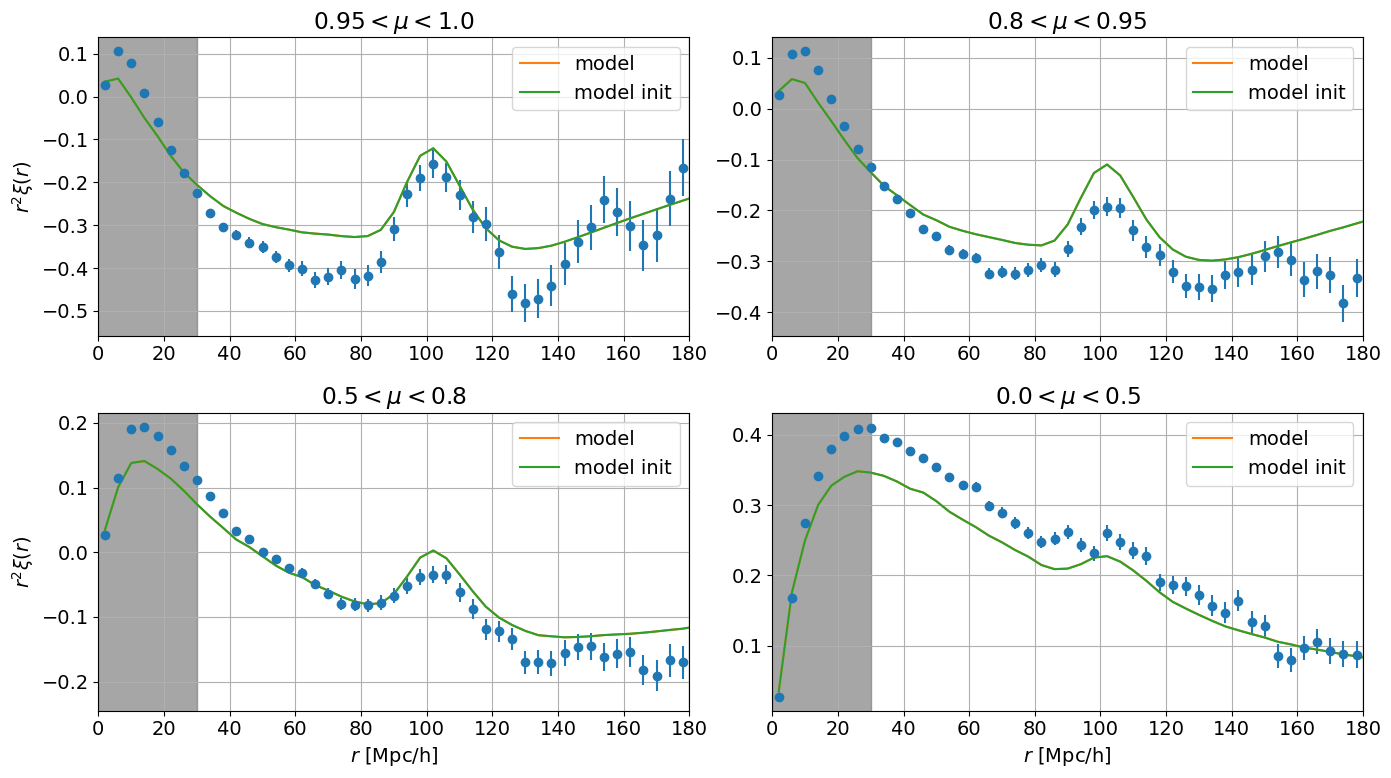

In [33]:
# Plot vega model in wedges (note this is set up in forecasting mode, so the model doesn't need to look like a good fit to the data)
vega = VegaInterface('$HOME/repos/vega/cobaya_interface/configs/complex_main.ini')
vega.plots.plot_4wedges(models=[vega_model['lyalya_lyalya'], vega_model_init['lyalya_lyalya']],
                        labels=['model', 'model init'], corr_name='lyalya_lyalya',
                        model_colors=['C1', 'C2'])

In [7]:
# Run minimizer
updated_info, sampler = run(info_minimize)

[camb] `camb` module loaded successfully from /global/u2/w/wmturner/.conda/envs/lya-directfit/lib/python3.12/site-packages/code/CAMB/camb
INFO: reading input Pk /global/homes/w/wmturner/repos/vega/cobaya_interface/templates/DESI-2024_z_2.33_new_k-grid.fits
Reading data file /pscratch/sd/w/wmturner/LyA-directfit/correlations/true_cont/cf_lya_lya_0_10_no-project-exp_nodist_stackedcov.fits.gz

Reading distortion matrix file /pscratch/sd/w/wmturner/LyA-directfit/correlations/contfit/old-mock/dmat_lya_lya_0_10_z-evol.fits.gz

sample params: {'limits': {}, 'values': {}, 'errors': {}, 'fix': {}}
LOG: Full matrix is positive definite
LOG: Reduced matrix is positive definite
sample params: {'limits': {}, 'values': {}, 'errors': {}, 'fix': {}}
[minimize] Initializing
vega model computed
param values: {'_derived': {}, 'D_H_fid': 853.772253428897, 'D_M_fid': 3882.64266625345, 'As': 2.1e-09, 'ns': 0.9649, 'bias_LYA': -0.11748975549395294, 'beta_LYA': 1.6218288124927878, 'H0': 67.36, 'ombh2': 0.0223

In [8]:
updated_info["params"].keys()

dict_keys(['D_H_fid', 'D_M_fid', 'logA', 'As', 'ns', 'log_biasLYA', 'bias_LYA', 'beta_LYA', 'H0', 'rdrag', 'H0_rd', 'ombh2', 'omch2', 'omegam', 'omegal', 'mnu', 'tau', 'or_photon', 'or_neutrino'])

In [9]:
products = sampler.products()

In [30]:
products['minimum']

   weight  minuslogpost  log_biasLYA  beta_LYA    omegam            As  \
0     1.0      2.291809     -0.86875  1.445323  0.315205  2.100000e-09   

   bias_LYA       rdrag     H0_rd     omch2    omegal  minuslogprior  \
0 -0.135285  147.099857  0.033052  0.120005  0.684716       2.282382   

   minuslogprior__0      chi2  chi2__custom_likelihood  
0          2.282382  0.018853                 0.018853  

In [11]:
x = products['result_object'].x
x0 = products['X0']
M = products['M']

In [12]:
H_inv_transformed = products['result_object']['hess_inv']

In [13]:
H_inv_transformed

,x0,x1,x2
x0,3.8e-05,-0.00619 (-0.921),-9.16e-07 (-0.099)
x1,-0.00619 (-0.921),1.19,5.97e-05 (0.036)
x2,-9.16e-07 (-0.099),5.97e-05 (0.036),2.26e-06


In [17]:
x_orig = np.dot(M,x)+x0
x_orig

array([-0.86874952,  1.44532325,  0.3152053 ])

In [15]:
H_inv_original = np.dot(M, np.dot(H_inv_transformed, M.T))

In [16]:
H_inv_original

array([[ 3.16257067e-06, -1.78605058e-05, -2.64566749e-08],
       [-1.78605058e-05,  1.18925689e-04,  5.97333531e-08],
       [-2.64566749e-08,  5.97333531e-08,  2.26293165e-08]])

Tests

In [3]:
def load_params(file):
    with open(file, "r") as f:
        lines = f.readlines()

    param_names = lines[0].split()[3:-3] 
    param_values = list(map(float, lines[1].split()[2:-4]))
    bestfit_params = dict(zip(param_names, param_values))
    del bestfit_params['rdrag']
    del bestfit_params['H0_rd']
    del bestfit_params['omch2']
    del bestfit_params['omegal']
    # Add fixed cosmo params if needed
    if 'H0' not in bestfit_params:
        bestfit_params['As'] = 2.1e-09
        bestfit_params['ns'] = 0.9649
        bestfit_params['H0'] = 67.36
        bestfit_params['ombh2'] = 0.02237
        bestfit_params['omegam'] = 3.150944547e-01
    print("Loaded Best-Fit Parameters:", bestfit_params)
    return bestfit_params

In [4]:
# Load best-fit params from tests
bestfit_params_nuisance_cosmo = load_params("/pscratch/sd/w/wmturner/LyA-directfit/minimize_test/nuisance_cosmo/nuisance_cosmo.minimum.txt")
bestfit_params_nuisance_template = load_params("/pscratch/sd/w/wmturner/LyA-directfit/minimize_test/nuisance_template/nuisance_template.minimum.txt")
bestfit_params_nuisance_model = load_params("/pscratch/sd/w/wmturner/LyA-directfit/minimize_test/nuisance_model/nuisance_model.minimum.txt")
bestfit_params_nuisance_omegam = load_params("/pscratch/sd/w/wmturner/LyA-directfit/minimize_test/nuisance_omegam/nuisance_omegam.minimum.txt")

Loaded Best-Fit Parameters: {'ns': 0.9599042, 'bias_LYA': -0.11597891, 'beta_LYA': 1.6801349, 'H0': 67.836575, 'ombh2': 0.023284998, 'omegam': 0.31815715}
Loaded Best-Fit Parameters: {'bias_LYA': -0.1170018, 'beta_LYA': 1.6699607, 'As': 2.1e-09, 'ns': 0.9649, 'H0': 67.36, 'ombh2': 0.02237, 'omegam': 0.3150944547}
Loaded Best-Fit Parameters: {'bias_LYA': -0.11702174, 'beta_LYA': 1.6716872, 'As': 2.1e-09, 'ns': 0.9649, 'H0': 67.36, 'ombh2': 0.02237, 'omegam': 0.3150944547}
Loaded Best-Fit Parameters: {'bias_LYA': -0.11702555, 'beta_LYA': 1.6712351, 'omegam': 0.3150944547, 'As': 2.1e-09, 'ns': 0.9649, 'H0': 67.36, 'ombh2': 0.02237}


In [27]:
model.loglike(bestfit_params_nuisance_cosmo)
likelihood_instance = model.likelihood['custom_likelihood']
vega_model = likelihood_instance.vega_model

vega model computed
param values: {'_derived': {}, 'D_H_fid': 853.772253428897, 'D_M_fid': 3882.64266625345, 'As': 2.1e-09, 'ns': 0.9599042, 'bias_LYA': -0.11597891, 'beta_LYA': 1.6801349, 'H0': 67.836575, 'ombh2': 0.023284998, 'omch2': 0.12247944976201303, 'or_photon': 5.4502399977451e-05, 'or_neutrino': 2.51353764750397e-05, 'omnuh2': 0.000644866570625114, 'omk': 0.0, 'ap_full': 0.9955741497729758, 'at_full': 0.9973356239256528}
template chi2: 1.6295703449890289
chi2: 0.2572466655386523 



In [8]:
# get model for other tests w/ fixed cosmo params
model.loglike(bestfit_params_nuisance_template)
likelihood_instance = model.likelihood['custom_likelihood']
vega_model_nuisance_template = likelihood_instance.vega_model

model.loglike(bestfit_params_nuisance_model)
likelihood_instance = model.likelihood['custom_likelihood']
vega_model_nuisance_model = likelihood_instance.vega_model

model.loglike(bestfit_params_nuisance_omegam)
likelihood_instance = model.likelihood['custom_likelihood']
vega_model_nuisance_omegam = likelihood_instance.vega_model

vega model computed
param values: {'_derived': {}, 'D_H_fid': 853.772253428897, 'D_M_fid': 3882.64266625345, 'As': 2.1e-09, 'ns': 0.9649, 'bias_LYA': -0.1170018, 'beta_LYA': 1.6699607, 'H0': 67.36, 'ombh2': 0.02237, 'omch2': 0.11995486158334986, 'or_photon': 5.4502399977451e-05, 'or_neutrino': 2.51353764750397e-05, 'omnuh2': 0.000644866570625114, 'omk': 0.0, 'ap_full': 1.0000010375228636, 'at_full': 1.000000581887338}
template chi2: 8.94024081209328e-07
chi2: 0.07068029862145409 

vega model computed
param values: {'_derived': {}, 'D_H_fid': 853.772253428897, 'D_M_fid': 3882.64266625345, 'As': 2.1e-09, 'ns': 0.9649, 'bias_LYA': -0.11702174, 'beta_LYA': 1.6716872, 'H0': 67.36, 'ombh2': 0.02237, 'omch2': 0.11995486158334986, 'or_photon': 5.4502399977451e-05, 'or_neutrino': 2.51353764750397e-05, 'omnuh2': 0.000644866570625114, 'omk': 0.0, 'ap_full': 1.0000010375228636, 'at_full': 1.000000581887338}
template chi2: 0.0660468057085562
chi2: 0.0045682250977334615 

vega model computed
param v

In [9]:
likelihood_instance.vega_fake_data

array([ 8.69644506e-03,  4.84955735e-03,  2.78115157e-03, ...,
       -1.24597306e-06, -1.18060449e-06, -1.11748118e-06])

In [35]:
vega.plots.plot_4wedges?

Signature:
vega.plots.plot_4wedges(
    mu_bins=(0, 0.5, 0.8, 0.95, 1),
    models=None,
    cov_mat=None,
    labels=None,
    data=None,
    cross_flag=False,
    corr_name='lyaxlya',
    models_only=False,
    data_only=False,
    data_label=None,
    figsize=(14, 8),
    mu_bin_labels=False,
    fig=None,
    **kwargs,
)
Docstring:
Plot the correlations into four wedges defined by the limits in mu_bins

Parameters
----------
mu_bins : tuple, optional
    Limits of mu bins that define the two wedges, by default (0, 0.5, 1)
models : List[array] or List[dict], optional
    List of models to plot, by default None
cov_mat : array or dict, optional
    Covariance matrix as an array or a dictionary of components, by default None
labels : List[str], optional
    List of labels for the models, by default None
data : array or dict, optional
    Data vector as an array or a dictionary of components, by default None
cross_flag : bool, optional
    Whether the wedge is for the cross-correlation

In [10]:
f = fits.open('/pscratch/sd/w/wmturner/picca_runs_v3/uncontaminated_mock/truth/full/cf_lya_x_lya_exp_no-dist.fits')
mock_cov = f[1].data['CO']

INFO: reading input Pk /global/homes/w/wmturner/repos/vega/cobaya_interface/templates/DESI-2024_z_2.33_new_k-grid.fits
Reading data file /pscratch/sd/w/wmturner/picca_runs_v3/uncontaminated_mock/truth/full/cf_lya_x_lya_exp_no-dist.fits

sample params: {'limits': {}, 'values': {}, 'errors': {}, 'fix': {}}


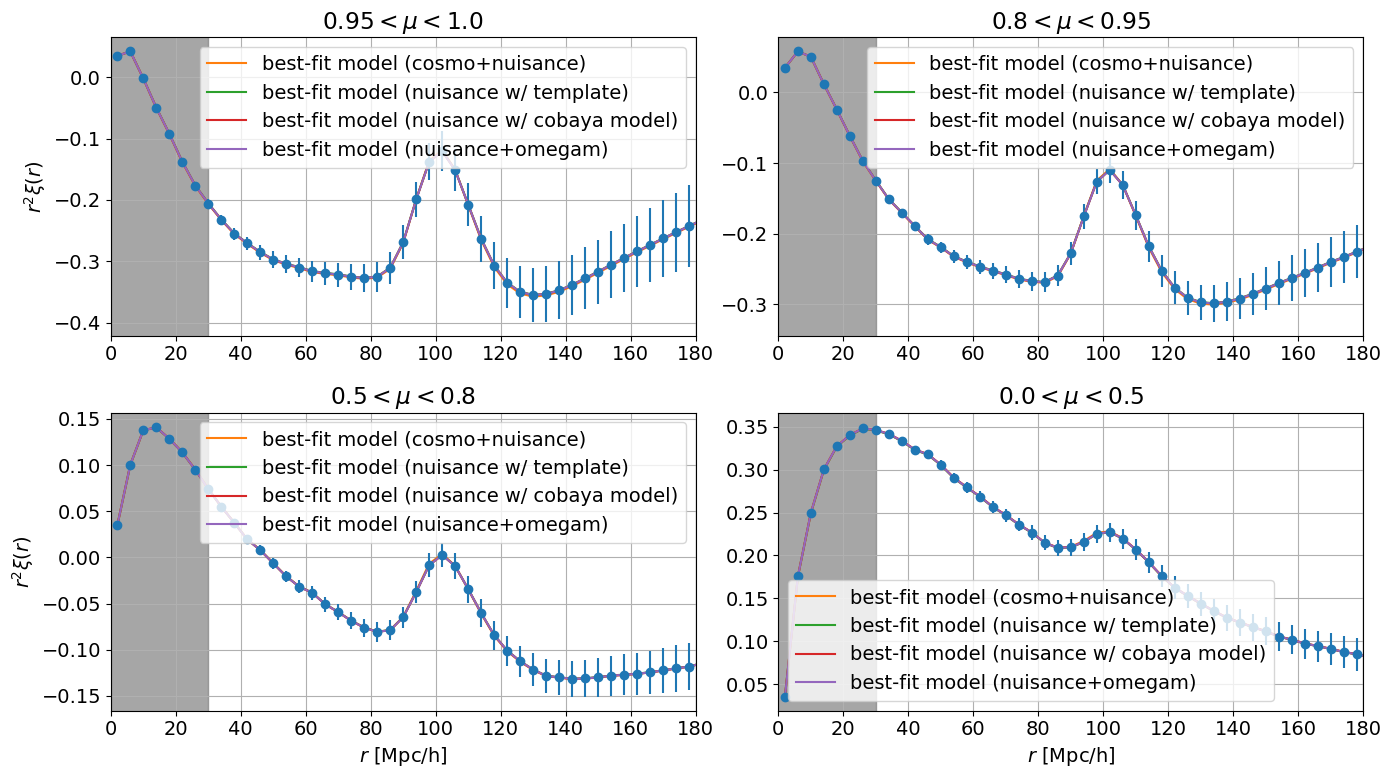

In [11]:
# Plot vega models in wedges
vega = VegaInterface('$HOME/repos/vega/cobaya_interface/configs/complex_main.ini')
vega.plots.plot_4wedges(data = likelihood_instance.vega_fake_data,
                        models=[vega_model['lyalya_lyalya'], vega_model_nuisance_template['lyalya_lyalya'],
                                vega_model_nuisance_model['lyalya_lyalya'], vega_model_nuisance_omegam['lyalya_lyalya']],
                        labels=['best-fit model (cosmo+nuisance)', 'best-fit model (nuisance w/ template)',
                               'best-fit model (nuisance w/ cobaya model)', 'best-fit model (nuisance+omegam)'],
                        corr_name='lyalya_lyalya',
                        model_colors=['C1', 'C2', 'C3', 'C4'])

In [13]:
# Residuals
nuisance_model_residual = vega_model_nuisance_template['lyalya_lyalya'] - vega_model_nuisance_model['lyalya_lyalya']
cobaya_template_residual = vega_model_nuisance_template['lyalya_lyalya'] - vega_model['lyalya_lyalya']
omegam_template_residual = vega_model_nuisance_template['lyalya_lyalya'] - vega_model_nuisance_omegam['lyalya_lyalya']

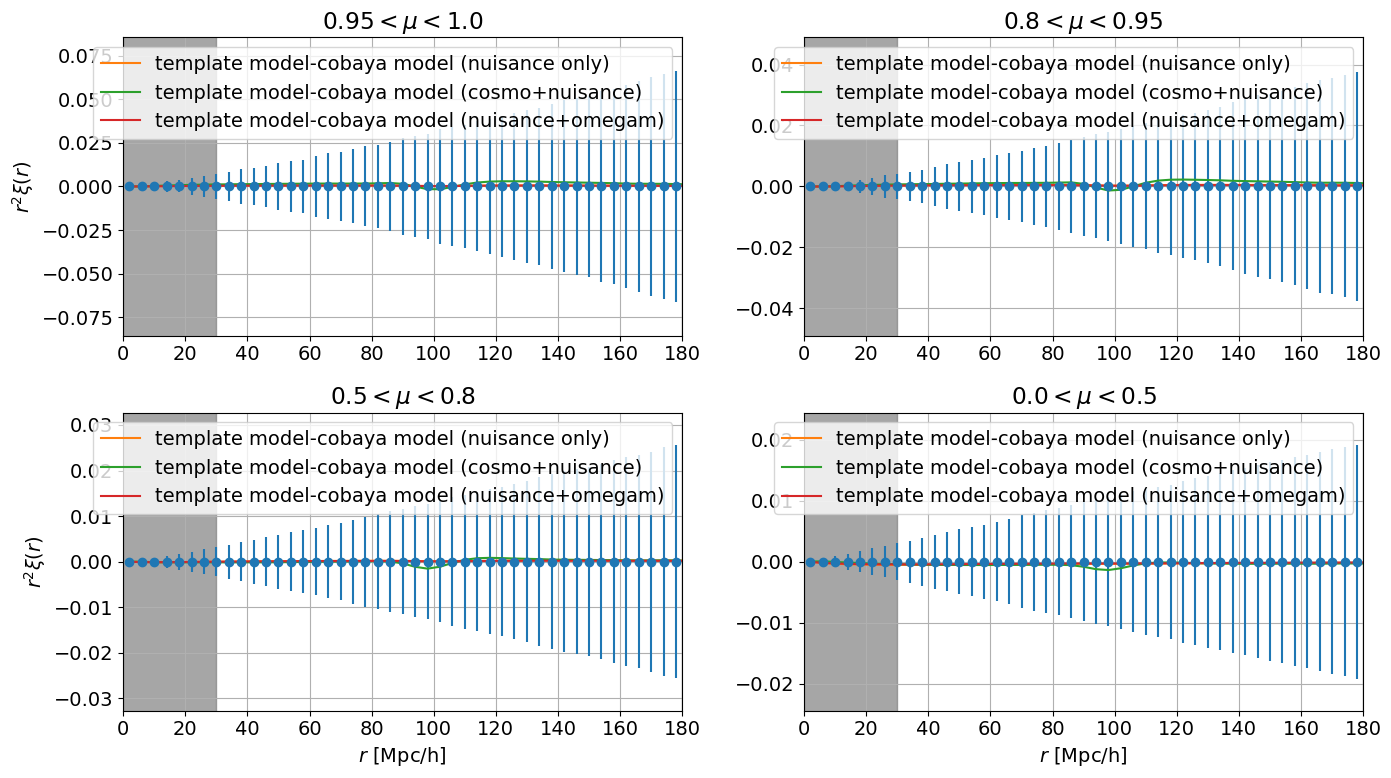

In [14]:
vega.plots.plot_4wedges(models=[nuisance_model_residual, cobaya_template_residual, omegam_template_residual],
                        labels=['template model-cobaya model (nuisance only)', 'template model-cobaya model (cosmo+nuisance)',
                               'template model-cobaya model (nuisance+omegam)'],
                        corr_name='lyalya_lyalya',
                        model_colors=['C1', 'C2', 'C3'], cov_mat = mock_cov, data = np.zeros(2500))

SNR plots

In [16]:
# Read in cov matrices
nodist = fits.open('/pscratch/sd/w/wmturner/picca_runs_v3/uncontaminated_mock/truth/full/cf_lya_x_lya_exp_no-dist.fits')
dist = fits.open('/pscratch/sd/w/wmturner/picca_runs_v3/uncontaminated_mock/continuum_fitting/full/cf_lya_x_lya_exp.fits')

# Line-of-sight
cov4d_nodist_los = nodist[1].data['CO'].reshape(50, 50, 50, 50)
cov4d_dist_los = dist[1].data['CO'].reshape(50, 50, 50, 50)
cov_nodist_los = np.transpose(cov4d_nodist_los).reshape(2500, 2500)
cov_dist_los = np.transpose(cov4d_dist_los).reshape(2500, 2500)

block_nodist_los = cov_nodist_los[:50, :50]
block_dist_los = cov_dist_los[:50, :50]
var_nodist_los, var_dist_los = np.diagonal(block_nodist_los), np.diagonal(block_dist_los)

# Transverse
cov4d_nodist_t = nodist[1].data['CO'].reshape(50, 50, 50, 50)
cov4d_dist_t = dist[1].data['CO'].reshape(50, 50, 50, 50)
cov_nodist_t = cov4d_nodist_t.reshape(2500, 2500)
cov_dist_t = cov4d_dist_t.reshape(2500, 2500)

block_nodist_t = cov_nodist_t[:50, :50]
block_dist_t = cov_dist_t[:50, :50]
var_nodist_t, var_dist_t = np.diagonal(block_nodist_t), np.diagonal(block_dist_t)

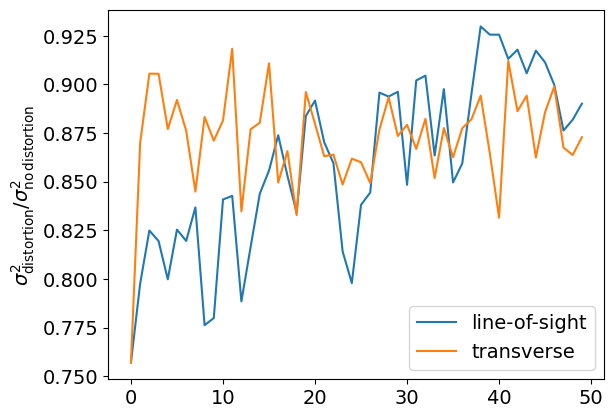

In [19]:
# Plot variance ratio
plt.plot(var_dist_los/var_nodist_los, label='line-of-sight')
plt.plot(var_dist_t/var_nodist_t, label='transverse')
plt.ylabel(r'$\sigma^2_{\rm distortion}$/$\sigma^2_{\rm no\,distortion}$')
plt.legend()

In [23]:
# Using fake data as correlation data (run first with no distortion)
fakedata_nodist = likelihood_instance.vega_fake_data

In [28]:
# Using fake data as correlation data (run second with distortion)
fakedata_dist = likelihood_instance.vega_fake_data

In [31]:
# LOS
xi_nodist_los = np.abs(fakedata_nodist.reshape(50,50).T.reshape(2500)[:50])
xi_dist_los = np.abs(fakedata_dist.reshape(50,50).T.reshape(2500)[:50])

# Transverse
xi_dist_t = np.abs(fakedata_nodist[:50])
xi_nodist_t = np.abs(fakedata_dist[:50])

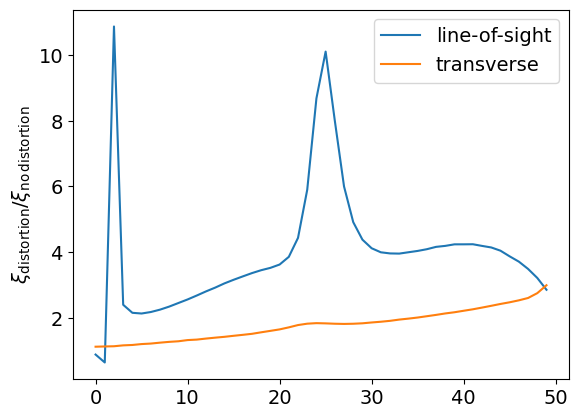

In [33]:
# Plot signal ratio
plt.plot(xi_dist_los/xi_nodist_los, label='line-of-sight')
plt.plot(xi_dist_t/xi_nodist_t, label='transverse')
plt.ylabel(r'$\xi_{\rm distortion}$/$\xi_{\rm no\,distortion}$')
plt.legend()

Text(0, 0.5, 'SNR$_{\\rm distortion}$/SNR$_{\\rm no\\,distortion}$')

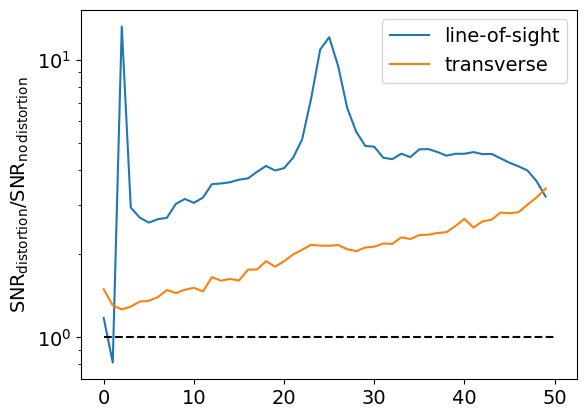

In [32]:
snr_nodist_los = xi_nodist_los/var_nodist_los
snr_dist_los = xi_dist_los/var_dist_los
snr_nodist_t = xi_nodist_t/var_nodist_t
snr_dist_t = xi_dist_t/var_dist_t

plt.plot(snr_dist_los/snr_nodist_los, label='line-of-sight')
plt.plot(snr_dist_t/snr_nodist_t, label='transverse')
plt.legend()
plt.hlines(1,0,50,'k','--')
plt.yscale('log')
plt.ylabel(r'SNR$_{\rm distortion}$/SNR$_{\rm no\,distortion}$')